<a href="https://colab.research.google.com/github/tbitai/bayes-or-spam/blob/main/bayes_or_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayes or Spam?

This is an analysis of Bayesian spam filtering from the viewpoint of Bayesian epistemology. I'll review the Bayesian spam filtering algorithm, point out where it deviates from the principles of Bayesian epistemology, and present test results showing that the "principled" Bayesian spam filtering is also more effective.

Bayesian spam filtering is one of the leading technologies of tackling spam. In his 2002 essay, [*A Plan for Spam*](http://paulgraham.com/spam.html), Paul Graham described the first effective Bayesian spam filtering algorithm. Today's Bayesian spam filters use essentially the same algorithm.

Graham's motivation was that his earlier spam filters looking for individual spam features (e.g. does it contain `"click"`?) got stuck at recognizing the "last few percent of spams". As he writes, Bayesian spam filters recognized more of these, e.g. `"ff0000"` (red's hexa code used in HTML).

## Preparing the test dataset

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools

We're going to use the [Enron spam dataset collection](http://www2.aueb.gr/users/ion/data/enron-spam/index.html)'s `Enron1` dataset:

In [ ]:
ds_url = 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz'
ds_path = tf.keras.utils.get_file(origin=ds_url, untar=True)

1818624/1802573 [==============================] - 1s 1us/step


In [ ]:
ds_base_kwargs = dict(directory=ds_path, seed=42, validation_split=0.1)
ds_train = tf.keras.utils.text_dataset_from_directory(**ds_base_kwargs, 
                                                      subset='training')

for i, label in enumerate(ds_train.class_names):
  print(f'{i}: {label}')
for text, label in ds_train.unbatch().take(5).concatenate(
                   ds_train.unbatch().filter(lambda _, l: l == 1).take(5)):
  print(text.numpy())
  print(label.numpy())

Found 5172 files belonging to 2 classes.
Using 4655 files for training.
0: ham
1: spam
b'Subject: meter variances - ua 4 clean - up\r\ndaren / vance -\r\nthe two meters below are new and have unallocatable flow . . . . . . . i will need a\r\npurchase for each of them . please respond with a deal number , or further\r\nsuggestions for resolution so that i can clear this up as soon as possible .\r\nmary\r\nenron on 09 / 19 / 2000 08 : 44 am - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\nkatherine benedict @ ect\r\n09 / 18 / 2000 04 : 53 pm\r\nto : mary poorman / na / enron @ enron , fred boas / hou / ect @ ect , aimee\r\nlannou / hou / ect @ ect\r\ncc :\r\nsubject : meter variances - ua 4 clean - up\r\nhi guys ,\r\nplease take a look at the following meters which are showing up with\r\nvariances on my ua 4 report . once the variance has been cleared , please send\r\nme an e - mail . please try to clear these within the next couple of days .\r\nthanks ,\r\nkathy benedict\r\nmete

## Graham's algorithm

Here's an approximate Python implementation of Graham's algorithm:

In [ ]:
def tokenize(text):
    return tf.keras.preprocessing.text.text_to_word_sequence(
        text.decode('latin_1')[9:],  # Remove 'Subject: ' from the beginning 
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\r'  # Default + '\r'
        )

for text, _ in ds_train.unbatch().take(5):
  text_np = text.numpy()
  print(text_np)
  print(tokenize(text_np))

b'Subject: eastrans nomination change effective 9 / 8 / 00\r\nplease decrease deliveries to eastrans to 0 mmbtu / dy for 9 / 8 / 00\r\nthe redeliveries will be 0 as well .\r\nthe over - delivery quantity for the fuels cotton valley gas will be valued per\r\nparagraph 3 of the contract price ( per mmbtu ) section in the transaction\r\nagreement .'
['eastrans', 'nomination', 'change', 'effective', '9', '8', '00', 'please', 'decrease', 'deliveries', 'to', 'eastrans', 'to', '0', 'mmbtu', 'dy', 'for', '9', '8', '00', 'the', 'redeliveries', 'will', 'be', '0', 'as', 'well', 'the', 'over', 'delivery', 'quantity', 'for', 'the', 'fuels', 'cotton', 'valley', 'gas', 'will', 'be', 'valued', 'per', 'paragraph', '3', 'of', 'the', 'contract', 'price', 'per', 'mmbtu', 'section', 'in', 'the', 'transaction', 'agreement']
b'Subject: eastrans nomination effective 5 / 1 / 01\r\neffective 5 / 1 / 01 , the deliveries and redeliveries will be 0 mmbtu / dy .\r\nthe transaction agreement will not be utilized .'


In [ ]:
good = {}
bad = {}
for text_batch, label_batch in ds_train:
  for i in range(len(text_batch)):
    text = text_batch.numpy()[i]
    label = label_batch.numpy()[i]
    for token in tokenize(text):
      good_or_bad = bad if label == 1 else good
      good_or_bad.setdefault(token, 0)
      good_or_bad[token] += 1

def dslice(dictionary, stop):
  return dict(itertools.islice(dictionary.items(), stop))

print(dslice(good, 10))
print(dslice(bad, 10))

{'txu': 218, 'fuels': 167, 'sds': 28, 'nomination': 536, 'for': 7254, 'january': 339, '2001': 1830, 'attached': 978, 'is': 4409, 'the': 16460}
{'online': 234, 'pahrma': 2, 'cy': 5, 'you': 2471, 'want': 190, 'welcome': 13, 'to': 4650, 'health': 100, 'suite': 60, 'chek': 1}


In [ ]:
word_probs = {}
for word in {**good, **bad}.keys():
  if word in word_probs:
    continue
  g = 2 * good.get(word, 0)
  b = bad.get(word, 0)
  word_probs[word] = b / (g + b)
  
print(dslice(word_probs, 10))

{'txu': 0.0, 'fuels': 0.0029850746268656717, 'sds': 0.0, 'nomination': 0.0009319664492078285, 'for': 0.13647997143027202, 'january': 0.08254397834912043, '2001': 0.001091703056768559, 'attached': 0.006602336211274758, 'is': 0.1873560040549258, 'the': 0.16666666666666666}


In [ ]:
def get_word_prob(word):
  return word_probs.get(word, 0.4)

print(get_word_prob('enron'))
print(get_word_prob('company'))
print('neverseen' not in word_probs)
print(get_word_prob('neverseen'))

0.0
0.44625407166123776
True
0.4


In [ ]:
def combine(probs):
    prod = np.prod(probs)
    neg_prod = np.prod([1 - p for p in probs])
    return prod / (prod + neg_prod)

In [ ]:
def get_text_prob(text):
  words = tokenize(text)
  probs = sorted([get_word_prob(w) for w in words], 
                 key=lambda p: abs(p - 0.5),
                 reverse=True)
  return combine(probs[:15])

print(get_text_prob(b'Subject: sex'))
print(get_text_prob(b'Subject: Enron'))

0.974025974025974
0.0


In [ ]:
def predict_label(text):
  return 1 if get_text_prob(text) > 0.9 else 0

print(predict_label(b'Subject: sex'))
print(predict_label(b'Subject: Enron'))

1
0


Now let's set up our test dataset, and evaluate Graham's spam filter.

In [ ]:
ds_test = tf.keras.utils.text_dataset_from_directory(**ds_base_kwargs,
                                                     subset='validation')

for text, label in ds_test.unbatch().take(10):
  print(text.numpy())
  print(label.numpy())

Found 5172 files belonging to 2 classes.
Using 517 files for validation.
b'Subject: cdnow shipment confirmation\r\ndear daren ,\r\nthank you for shopping at cdnow . please keep this email invoice for\r\nyour records .\r\non april 3 we shipped your order number 17817331 for the following item :\r\nrobert earl keen : walking distance\r\nformat : cd quantity : 1 price : 12 . 99\r\nto the following address via u . s . postal service :\r\ndaren farmer\r\n5519 clarkston ln\r\nspring , tx 77379\r\ntotal number of items : 1\r\nsubtotal : $ 12 . 99\r\nshipping : $ 2 . 99\r\nsales tax : $ 0 . 00\r\n- - - - - - - - - -\r\nshipment total : $ 15 . 98\r\nyour order was billed to daren farmer . this shipment completes your\r\norder and is paid in full .\r\nmost orders arrive within 4 - 8 business days . however , in rare instances\r\nit may take up to 2 weeks .\r\nfor complete information about your order ( number 17817331 ) or to\r\nconfirm the status , click or copy / paste this link into your web 

In [ ]:
def evaluate(prediction, label):
  if prediction == 1 and label == 1:
    return 'true positive'
  elif prediction == 0 and label == 0:
    return 'true negative'
  elif prediction == 1:
    return 'false positive'
  else:
    return 'false negative'

print(evaluate(1, 1))
print(evaluate(0, 0))
print(evaluate(1, 0))
print(evaluate(0, 1))

true positive
true negative
false positive
false negative


In [ ]:
def predict_and_evaluate(tf_text, tf_label):
  return evaluate(predict_label(tf_text.numpy()), tf_label.numpy())

results = {'true positive': 0,
           'true negative': 0,
           'false positive': 0,
           'false negative': 0}
for t, l in ds_test.unbatch():
  results[predict_and_evaluate(t, l)] += 1

print(results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


{'true positive': 80, 'true negative': 369, 'false positive': 0, 'false negative': 68}


## Correcting Graham's bias

Here's a plot comparing Graham's biased probablities to the correct (original) ones:

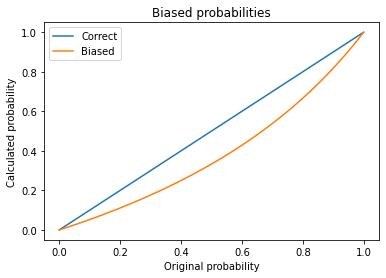

In [ ]:
def bias(p):
    return p / (2 - p)

x = np.linspace(0, 1, 100)
plt.plot(x, x, label='Correct')
plt.plot(x, bias(x), label='Biased')
plt.xlabel('Original probability')
plt.ylabel('Calculated probability')
plt.title('Biased probabilities')
plt.legend()

Let's see if the Bayesian filter with correct (non-biased) probabilies performs better.

In [ ]:
def correct(p):
    return (2 * p) / (p + 1)

word_probs = {w: correct(p) for (w, p) in word_probs.items()}

results = {'true positive': 0,
           'true negative': 0,
           'false positive': 0,
           'false negative': 0}
for t, l in ds_test.unbatch():
  results[predict_and_evaluate(t, l)] += 1

print(results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


{'true positive': 81, 'true negative': 369, 'false positive': 0, 'false negative': 67}
